In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from sklearn.preprocessing import OneHotEncoder

In [7]:
def load_dataset(filename):
    df = pd.read_csv(filename, encoding = "latin1", names = ["question", "intent"])
    df=df.dropna()
    print(df.head())
    print(df.isnull().any())
    intent = df["intent"]
    unique_intent = list(set(intent))
    question = list(df["question"])
    return (intent, unique_intent, question)

In [8]:
intent, unique_intent, question = load_dataset("raw_data_augmented_final.csv")

            question  intent
0                 yo  gen_hi
1               Heya  gen_hi
2            Namaste  gen_hi
3                Hey  gen_hi
4  Great see to you!  gen_hi
question    False
intent      False
dtype: bool


In [9]:
print(question[100:105])
print(unique_intent)

['. hooman?', 'You are human?', 'Are you a person or a bot?', 'Humans me amuse are, you one?', "You ' not re human"]
['ieee_github', 'ieee_how_long', 'gen_who_made', 'ieee_domains', 'ieee_be_part_who', 'gen_human', 'ieee_past_events', 'ieee_sponsor', 'gen_help', 'ieee_projects', 'gen_who_you', 'ieee_what_does', 'gen_hi', 'ieee_collab', 'gen_thanks', 'ieee_other_college', 'ieee_current_board', 'ieee_other_linked', 'ieee_social_media', 'gen_query', 'ieee_what', 'gen_bot', 'ieee_future_events', 'ieee_further_contact', 'gen_how_you', 'ieee_techloop', 'gen_bye']


In [10]:
def cleaning(question):
    words = []
    for s in question:
        clean = re.sub(r'[^a-z A-Z]', " ", s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
    
    return words  

In [11]:
cleaned_words = cleaning(question)
print(len(cleaned_words))

14385


In [12]:
print(cleaned_words[:8])

[['yo'], ['heya'], ['namaste'], ['hey'], ['great', 'see', 'to', 'you'], ['ssup'], ['whatup'], ['yo']]


In [13]:
def create_tokenizer(words, filters = '!"#$%&*+,-./:;<=>?@[\]^`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    return token

In [14]:
def max_length(words):
    return(len(max(words, key = len)))

In [15]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 2909 and Maximum length = 58


In [16]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [17]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [18]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [19]:
padded_doc = padding_doc(encoded_doc, max_length)

In [20]:
padded_doc[115:118]

array([[ 94,  15,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [464,  15,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [ 15,  14,  13, 433,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])

In [21]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (14385, 58)


In [22]:
output_tokenizer = create_tokenizer(unique_intent)

In [23]:
output_tokenizer.word_index

{'ieee_github': 1,
 'ieee_how_long': 2,
 'gen_who_made': 3,
 'ieee_domains': 4,
 'ieee_be_part_who': 5,
 'gen_human': 6,
 'ieee_past_events': 7,
 'ieee_sponsor': 8,
 'gen_help': 9,
 'ieee_projects': 10,
 'gen_who_you': 11,
 'ieee_what_does': 12,
 'gen_hi': 13,
 'ieee_collab': 14,
 'gen_thanks': 15,
 'ieee_other_college': 16,
 'ieee_current_board': 17,
 'ieee_other_linked': 18,
 'ieee_social_media': 19,
 'gen_query': 20,
 'ieee_what': 21,
 'gen_bot': 22,
 'ieee_future_events': 23,
 'ieee_further_contact': 24,
 'gen_how_you': 25,
 'ieee_techloop': 26,
 'gen_bye': 27}

In [24]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [25]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [26]:
encoded_output.shape

(14385, 1)

In [27]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [28]:
output_one_hot = one_hot(encoded_output)

In [29]:
output_one_hot.shape

(14385, 27)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
x_train, x_val, y_train, y_val = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

In [32]:
print("Shape of train_X = %s and train_Y = %s" % (x_train.shape, y_train.shape))
print("Shape of val_X = %s and val_Y = %s" % (x_val.shape, y_val.shape))

Shape of train_X = (11508, 58) and train_Y = (11508, 27)
Shape of val_X = (2877, 58) and val_Y = (2877, 27)


In [33]:
model=Sequential()
model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = True))
#model.add(GRU(128,return_sequences=True))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
#model.add(GRU(128,return_sequences=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64, activation = "relu"))    ###
model.add(Dropout(0.5))
#model.add(Dense(96, activation = "relu"))    ###
#model.add(Dropout(0.3))
model.add(Dense(27, activation = "softmax"))

In [34]:
opt = SGD(lr=0.01, momentum=0.9)
#model.compile(loss='kullback_leibler_divergence', optimizer='adam', metrics=['accuracy'])
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [35]:
filename = 'ieee_bot_test1.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#history = model.fit(x_train, y_train, epochs = 100, batch_size = 8, validation_split=0.2, verbose=1, callbacks=[checkpoint])
history = model.fit(x_train, y_train, epochs = 20, batch_size = 8, validation_data= (x_val, y_val), verbose=1,callbacks=[checkpoint])

Epoch 1/20
1439/1439 [==============================] - 46s 27ms/step - loss: 2.3811 - accuracy: 0.2929 - val_loss: 0.3328 - val_accuracy: 0.9027

Epoch 00001: val_loss improved from inf to 0.33281, saving model to ieee_bot_test1.h5
Epoch 2/20
1439/1439 [==============================] - 36s 25ms/step - loss: 0.3565 - accuracy: 0.9102 - val_loss: 0.1489 - val_accuracy: 0.9625

Epoch 00002: val_loss improved from 0.33281 to 0.14891, saving model to ieee_bot_test1.h5
Epoch 3/20
1439/1439 [==============================] - 36s 25ms/step - loss: 0.1556 - accuracy: 0.9630 - val_loss: 0.1597 - val_accuracy: 0.9572

Epoch 00003: val_loss did not improve from 0.14891
Epoch 4/20
1439/1439 [==============================] - 36s 25ms/step - loss: 0.1456 - accuracy: 0.9642 - val_loss: 0.1848 - val_accuracy: 0.9579

Epoch 00004: val_loss did not improve from 0.14891
Epoch 5/20
1439/1439 [==============================] - 37s 26ms/step - loss: 0.1061 - accuracy: 0.9721 - val_loss: 0.1200 - val_accur

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 58, 128)           372352    
_________________________________________________________________
bidirectional (Bidirectional (None, 58, 256)           263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                1755      
Total params: 1,047,963
Trainable params: 1,047,963
Non-trainable params: 0
______________________________________________

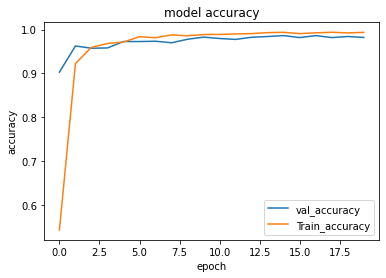

In [37]:
def plotloss(history):
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['val_accuracy', 'Train_accuracy'], loc = 'lower right')
    plt.show()
    
plotloss(history)

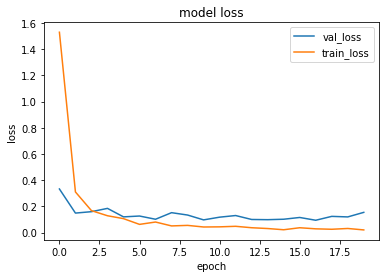

In [38]:
def plotloss1(history):
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'train_loss'], loc = 'best')
    plt.show()
    
plotloss1(history)

In [39]:
_,acc=model.evaluate(x_val,y_val)
print(acc*100)

90/90 [==============================] - 1s 14ms/step - loss: 0.1545 - accuracy: 0.9819
98.19256067276001


In [40]:
model = load_model("ieee_bot_test1.h5")

In [41]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]'," ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    #print(test_word)            ##
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))
    
    test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
    x = padding_doc(test_ls, max_length)
  
    pred = model.predict(x)
  
    return pred 

In [42]:
def get_final_output(pred, classes):
    predictions = pred[0]
 
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
    pred_intent=classes[0]
 
    for i in range(5):
        print("%s has confidence = %s" % (classes[i], (predictions[i])))
    return pred_intent


In [43]:
def user():
    text=input('Enter your query : ')
    pred = predictions(text)
    get_final_output(pred,unique_intent)

In [45]:
user()

Enter your query : what is IEEE?
ieee_what has confidence = 1.0
ieee_social_media has confidence = 2.8406252e-10
ieee_what_does has confidence = 5.6077944e-11
ieee_be_part_who has confidence = 4.664177e-11
ieee_other_linked has confidence = 4.1401996e-11
